In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score, auc
import random

In [88]:
# Read from csv (without second list in daughter columns - see data_loading.ipynb)
train_df = pd.read_csv('new_train_data.csv')
test_df = pd.read_csv('new_test_data.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(df, cols, n_col):
    for col in cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

# Create node feature array: [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)


Data preprocessing

In [ ]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT', 'Gauss'] # Gauss added later to test
test_jet_cols = ['Jet1_Eta', 'Jet1_PT', 'Gauss']

# Features columns (daughter kinematics + Eta and pT)
train_f_cols = train_d_cols + train_jet_cols
test_f_cols = test_d_cols + test_jet_cols

# Duplicate single features for each node and convert strings into float lists
train_df = duplicate(train_df, ['Jet0_PT', 'Jet0_Eta', 'IsB'], 'Jet0_nDaughters')
test_df = duplicate(test_df, ['Jet1_PT', 'Jet1_Eta', 'IsB'], 'Jet1_nDaughters')
train_df = convert_to_lists(train_df, train_d_cols)
test_df = convert_to_lists(test_df, test_d_cols)

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

# Cut out some data for quicker runs
cut_train_df = pd.concat([train_df.head(1000), train_df.iloc[100000:101000]]) 
cut_test_df = pd.concat([test_df.head(1000), test_df.iloc[100000:101000]])

Test - create gaussian distribution around 10 for background and 25 for signal (std = 5) to see if it picks up on it

In [ ]:
def generate_gaussian(mean, std_dev):
    return random.gauss(mean, std_dev)

def generate_gaussian_for_list(row, mean1, mean2, std_dev):
    if isinstance(row['IsB'], list):
        gauss_list = []
        for is_b_val in row['IsB']:
            if is_b_val == 1:
                gauss_list.append(generate_gaussian(mean1, std_dev))
            if is_b_val == 0:
                gauss_list.append(generate_gaussian(mean2, std_dev))
        return gauss_list

cut_train_df['Gauss'] = cut_train_df.apply(lambda row: generate_gaussian_for_list(row, 10, 25, 5), axis=1)
cut_test_df['Gauss'] = cut_test_df.apply(lambda row: generate_gaussian_for_list(row, 10, 25, 5), axis=1)

In [ ]:
cut_train_df.Gauss

0         [27.057268146753078, 20.639046041650445, 21.86...
1         [30.0743777438498, 25.24476973012406, 19.55037...
2         [-0.7386166152620017, 23.630213794716777, 15.1...
3         [19.915657849401157, 32.296976356001295, 22.76...
4         [15.971540660375368, 5.046591997875831, 17.524...
                                ...                        
100995    [13.429038185560046, 12.118553515860672, 2.563...
100996    [10.571988014802882, 9.20241392348421, 4.73516...
100997    [3.4271671019230334, 16.22448509642796, 19.017...
100998    [20.33882317377323, 17.19390029705507, 20.9121...
100999    [18.91903033512203, 15.693796347722735, 16.111...
Name: Gauss, Length: 2000, dtype: object

In [ ]:
cut_train_df.IsB

0                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
3         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4             [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
                                ...                        
100995    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
100996    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
100997     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
100998           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
100999           [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Name: IsB, Length: 2000, dtype: object

In [ ]:
# Create graphs for each jet
def create_data_objects(features_array, labels):
    data_objects = []
    for jet_idx, jet_features in enumerate(features_array):

        num_classes = 2 # binary classification
        x = torch.tensor(jet_features, dtype=torch.float)
        num_nodes = x.size(0)

        # Fully connected edges
        edge_index = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                edge_index.append([i, j])
        
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        y = torch.tensor(labels[jet_idx], dtype=torch.long)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(cut_train_df, train_f_cols)
test_features = node_features(cut_test_df, test_f_cols)

# Define labels - IsB = 1: b-jet, IsB = 0: not b-jet
train_labels = cut_train_df['IsB'].tolist()
test_labels = cut_test_df['IsB'].tolist()

# Create graphs for each jet
train_data = create_data_objects(train_features, train_labels)
test_data = create_data_objects(test_features, test_labels)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
cut_train_df.Gauss

0         [27.057268146753078, 20.639046041650445, 21.86...
1         [30.0743777438498, 25.24476973012406, 19.55037...
2         [-0.7386166152620017, 23.630213794716777, 15.1...
3         [19.915657849401157, 32.296976356001295, 22.76...
4         [15.971540660375368, 5.046591997875831, 17.524...
                                ...                        
100995    [13.429038185560046, 12.118553515860672, 2.563...
100996    [10.571988014802882, 9.20241392348421, 4.73516...
100997    [3.4271671019230334, 16.22448509642796, 19.017...
100998    [20.33882317377323, 17.19390029705507, 20.9121...
100999    [18.91903033512203, 15.693796347722735, 16.111...
Name: Gauss, Length: 2000, dtype: object

In [ ]:
train_features[0][0][31] # Gaussian features are included in the training data

27.057268146753078

In [ ]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GraphConv(len(train_f_cols), hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.bn1(self.conv1(x, edge_index))
        x = F.relu(x)
        x = self.bn2(self.conv2(x, edge_index))
        x = F.relu(x)
        x = self.bn3(self.conv3(x, edge_index))
        x = F.relu(x)
        
        x = self.lin(x)
        
        return x

model = GNN()

In [133]:
class GNN(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.lin = torch.nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Node embeddings 
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = torch.sigmoid(x)
        x = self.lin(x)
        
        return x.squeeze(-1)

num_node_features = data.x.size(1)
model = GNN(num_node_features)


In [123]:
for data in train_loader:
    print(data.x.shape) # [num_nodes, num_features(32 including Gauss)]
    print(data.edge_index.shape) # [2, num_edges] fully connected
    print(data.y.shape) # labels
    print(data.batch.shape) # how many nodes in this batch
    print("x")

torch.Size([452, 32])
torch.Size([2, 7302])
torch.Size([452])
torch.Size([452])
x
torch.Size([517, 32])
torch.Size([2, 9115])
torch.Size([517])
torch.Size([517])
x
torch.Size([420, 32])
torch.Size([2, 6380])
torch.Size([420])
torch.Size([420])
x
torch.Size([462, 32])
torch.Size([2, 7750])
torch.Size([462])
torch.Size([462])
x
torch.Size([492, 32])
torch.Size([2, 8634])
torch.Size([492])
torch.Size([492])
x
torch.Size([467, 32])
torch.Size([2, 7537])
torch.Size([467])
torch.Size([467])
x
torch.Size([431, 32])
torch.Size([2, 6663])
torch.Size([431])
torch.Size([431])
x
torch.Size([426, 32])
torch.Size([2, 6388])
torch.Size([426])
torch.Size([426])
x
torch.Size([491, 32])
torch.Size([2, 8337])
torch.Size([491])
torch.Size([491])
x
torch.Size([487, 32])
torch.Size([2, 8143])
torch.Size([487])
torch.Size([487])
x
torch.Size([494, 32])
torch.Size([2, 8708])
torch.Size([494])
torch.Size([494])
x
torch.Size([525, 32])
torch.Size([2, 9611])
torch.Size([525])
torch.Size([525])
x
torch.Size([514,

In [156]:
# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop
def train():
    model.train()
    for data in train_loader:
        #print(f"x:  {data.x}")
        #print(f"x shape:  {data.x.shape}")
        #print(f"Edge index:  {data.edge_index}")
        #print(f"Edge index shape:  {data.edge_index.shape}")
        #print(f"y:  {data.y}")
        #print(f"y shape:  {data.y.shape}")
        optimizer.zero_grad()
        out = model(data)
        #print(out)
        loss = criterion(out, data.y.float())
        #print(loss)
        #clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        
    return loss.item()

def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data)
            #print(out)
            pred = (torch.sigmoid(out) > 0.5).float()
            #print(pred)
            correct = (pred.squeeze() == data.y.float()).sum().item()
            #print(correct)
            total_correct += correct
            #print(total_correct)
            total_samples += len(data.y)
            #print(total_samples)
    return total_correct / total_samples

num_epochs = 100
loss_values = []
for epoch in range(num_epochs):
    loss = train()
    loss_values.append(loss)
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    #scheduler.step(train_loss)

Epoch: 001, Loss: 0.6791, Train Acc: 0.5431, Test Acc: 0.5281
Epoch: 002, Loss: 0.6924, Train Acc: 0.5442, Test Acc: 0.5306
Epoch: 003, Loss: 0.6930, Train Acc: 0.5423, Test Acc: 0.5406
Epoch: 004, Loss: 0.7019, Train Acc: 0.5374, Test Acc: 0.5403
Epoch: 005, Loss: 0.6846, Train Acc: 0.5353, Test Acc: 0.5370
Epoch: 006, Loss: 0.6603, Train Acc: 0.5352, Test Acc: 0.5350
Epoch: 007, Loss: 0.7251, Train Acc: 0.5370, Test Acc: 0.5384
Epoch: 008, Loss: 0.6928, Train Acc: 0.5372, Test Acc: 0.5369
Epoch: 009, Loss: 0.6683, Train Acc: 0.5381, Test Acc: 0.5366
Epoch: 010, Loss: 0.6868, Train Acc: 0.5362, Test Acc: 0.5386
Epoch: 011, Loss: 0.6937, Train Acc: 0.5383, Test Acc: 0.5332
Epoch: 012, Loss: 0.6860, Train Acc: 0.5397, Test Acc: 0.5346
Epoch: 013, Loss: 0.7085, Train Acc: 0.5403, Test Acc: 0.5355
Epoch: 014, Loss: 0.7110, Train Acc: 0.5410, Test Acc: 0.5393
Epoch: 015, Loss: 0.6992, Train Acc: 0.5356, Test Acc: 0.5327
Epoch: 016, Loss: 0.6867, Train Acc: 0.5407, Test Acc: 0.5375
Epoch: 0

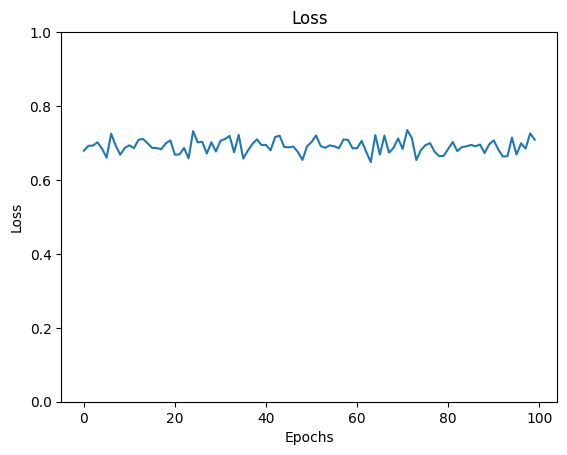

In [157]:
# Plot of loss for every training epoch
plt.plot(loss_values)
plt.title('Loss')
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.ylim(0,1);

In [135]:
# Check gradients (exploding or vanishing)
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()
    print('Grad norms:')
        
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

check_gradients()

Grad norms:
    conv1.bias: 0.000125
    conv1.lin.weight: 1.643668
    conv2.bias: 0.000157
    conv2.lin.weight: 1.893360
    lin.weight: 0.101439
    lin.bias: 0.006999


Compute ROC Curve and AUC

In [ ]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# Compute background rejection and signal efficiency
back_rej = 1 - fpr
sig_eff = tpr

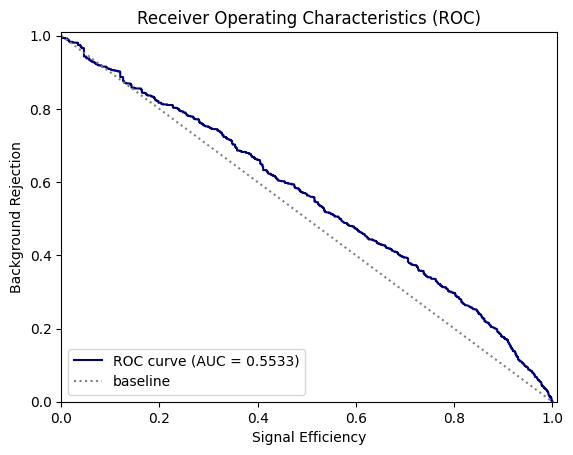

In [ ]:
# Plot ROC Curve and show AUC
plt.plot(sig_eff, back_rej, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [1, 0], color='grey', linestyle='dotted', label='baseline')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency' )
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower left')
plt.show()

Old Method for creating data object - incorrectly adds features

In [ ]:
# Creates list of node features (float) - features[x][y], x = row index, y = index of feature column
def node_features(df, features_cols):
    node_features_list = []
    node_features = []
    for i, row in df.iterrows():
        row_nodes = []
        for col in features_cols:
            feature = df.at[i, col]
            if isinstance(feature, list):
                node_features.extend(feature)
                if len(row_nodes) < len(feature):
                    row_nodes.extend([[] for _ in range(len(feature) - len(row_nodes))])
                for j, val in enumerate(feature):
                    row_nodes[j].append(val)
            else:
                node_features.append(feature)
                for node in row_nodes:
                        node.append(feature)
        node_features_list.extend(row_nodes)
    return node_features_list

# Creates a data object of each df
def create_data_object(df, features_cols):
    
    df = df.sample(frac=1).reset_index(drop=True) # shuffles data before creating data object
    data_list = []

    for i in range(len(df)):
        node_df = df.iloc[[i]]
        
        features = node_features(node_df, features_cols)
        num_nodes = len(features)

        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        x = torch.tensor(features, dtype=torch.float)
        y = torch.tensor(node_df['IsB'].iloc[0], dtype=torch.long)

        data = Data(x=x, edge_index=edge_index, y=y)
        data_list.append(data)
        
    return data_list